In [1]:
import numpy as np
import pandas as pd
import mat73
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines.statistics import logrank_test
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import scipy.io as sio
from lifelines.statistics import multivariate_logrank_test
from statsmodels.stats.multitest import multipletests
from scipy import stats
from scipy.stats import chi2_contingency

In [2]:
## Load data

In [3]:
km_clinical_data_df = pd.read_csv("km_pfs_data_669.csv")

In [4]:
censorlist = km_clinical_data_df['death_flag_list'].values
km_clinical_data_df['days_since_last_visit_list'] = km_clinical_data_df['days_since_last_visit_list'].fillna(-1)
event_duration = km_clinical_data_df['days_since_last_visit_list'].values/365

In [5]:
np.sum(km_clinical_data_df['mask_list'])

659

In [6]:
missing_subject_list = ['MMRF_2903','MMRF_2905','MMRF_2908','MMRF_2914','MMRF_2926',\
                        'MMRF_2938', 'MMRF_2939', 'MMRF_2941', 'MMRF_2946', 'MMRF_2947']

In [7]:
patient_list = pd.read_csv('subject_list_669.csv')

In [8]:
patient_list = patient_list['0'].values

In [9]:
patient_list = patient_list[1:]

In [10]:
number_of_patients = len(patient_list)

In [11]:
patients_mask = np.ones(number_of_patients,)
for n, patient_id in enumerate(patient_list): 
    if patient_id[0:9] in missing_subject_list: 
        patients_mask[n] = 0

patients_mask = patients_mask > 0

In [12]:
len(missing_subject_list)

10

In [13]:
for n, event in enumerate(event_duration): 
    if event < 0: 
        patients_mask[n] = 0
        
patients_mask = patients_mask > 0

In [14]:
sum(patients_mask)

659

In [15]:
event_duration = event_duration[patients_mask]

In [16]:
len(patient_list)

669

In [17]:
len(event_duration) 

659

In [18]:
censorlist = censorlist[patients_mask]

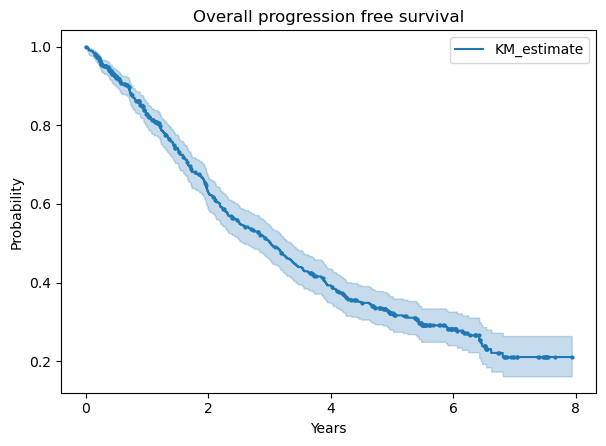

In [19]:
plt.figure()
ax = plt.subplot(111)
kmf = KaplanMeierFitter()
kmf.fit(event_duration,\
        censorlist)

kmf.plot_survival_function(ax=ax,  show_censors=True,\
                           censor_styles={'ms': 2, 'marker': 'o'}, ci_show=True)

plt.title('Overall progression free survival');
plt.xlabel('Years')
plt.ylabel('Probability')
plt.rcParams.update({'font.size': 18})
plt.tight_layout()

In [20]:
def get_cluster_summary(labels, clinical_data_df): 
    print("Number of clusters: ", len(np.unique(labels)))
    for n in np.unique(labels): 
        print("---- Cluster ", n, "-----")
        print('Age: ', np.round(np.mean(clinical_data_df[labels==n]['age_list'].values), 2), \
             "+/-", np.round(np.std(clinical_data_df[labels==n]['age_list'].values), 2))
        print("Sex: ")
        print(clinical_data_df[labels==n]['gender_list'].value_counts()) 
        print("ISS Stage: ")
        print(clinical_data_df[labels==n]['iss_list'].value_counts()) 
        print("Therapy: ")
        print(clinical_data_df[labels==n]['therapy_list'].value_counts()) 
        print()
        

In [21]:
# RNA 
data_dict = mat73.loadmat("/Users/anish/Documents/MSKCC/multiple-myeloma/matlab/scalar_curvature/overall_curvature_may4_rna.mat")
overall_curvature = data_dict['overall_curvature']

In [22]:
overall_curvature = overall_curvature[:, patients_mask]

In [23]:
print(overall_curvature.shape)

(33695, 659)


In [24]:
average_sil_list = [] 
num_clusters = 20

X = overall_curvature.T

for n_clusters in range(2, num_clusters):

    clusterer = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(X)

    output = multivariate_logrank_test(event_duration, cluster_labels, censorlist)
    
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,)
    average_sil_list.append(silhouette_avg)
    print('silhouette score: ', silhouette_avg, 'log rank p-value: ', output.p_value)

For n_clusters = 2
silhouette score:  0.04674743577455426 log rank p-value:  0.25788518199834737
For n_clusters = 3
silhouette score:  0.044510823704629415 log rank p-value:  0.09657468139661173
For n_clusters = 4
silhouette score:  0.04948578549664898 log rank p-value:  0.0172223781640441
For n_clusters = 5
silhouette score:  0.047282097977205347 log rank p-value:  0.03389203127114319
For n_clusters = 6
silhouette score:  0.051451107838132296 log rank p-value:  0.0016140991448944629
For n_clusters = 7
silhouette score:  0.047100677681081324 log rank p-value:  0.0017890881235056195
For n_clusters = 8
silhouette score:  0.02986089780431835 log rank p-value:  0.002122780948477748
For n_clusters = 9
silhouette score:  0.03198607011663758 log rank p-value:  0.0036906284031631184
For n_clusters = 10
silhouette score:  0.03449796354801204 log rank p-value:  0.006761225027907068
For n_clusters = 11
silhouette score:  0.028640420435547976 log rank p-value:  0.00996719493152882
For n_clusters =

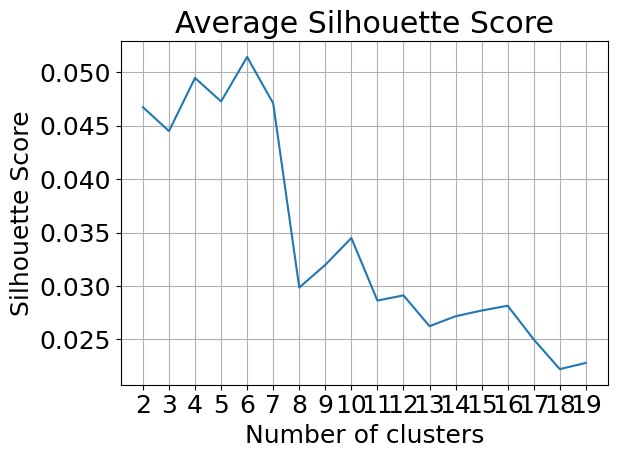

In [25]:
plt.figure()
plt.plot(list(range(2, num_clusters)), average_sil_list)
plt.xticks(list(range(2, num_clusters)))
plt.title('Average Silhouette Score')
plt.ylabel('Silhouette Score')
plt.xlabel('Number of clusters')
plt.grid("on")
plt.rcParams.update({'font.size': 14})

plt.tight_layout()

In [26]:
selected_patient_list = patient_list[patients_mask==True]
clinical_data_df = pd.read_csv('km_clinical_data_669.csv')
clinical_data_df = clinical_data_df[clinical_data_df['subjectIDlist'].isin(selected_patient_list)]
clinical_data_df = clinical_data_df.reset_index()

In [27]:
number_of_clusteres = 6

model = AgglomerativeClustering(n_clusters=number_of_clusteres)
labels = model.fit_predict(overall_curvature.T)

(array([0, 1, 2, 3, 4, 5]), array([263, 108,  98,  70,  84,  36]))
0.0016140991448944629
0 3.5424657534246577  years
1 2.4876712328767123  years
2 3.4246575342465753  years
3 2.0575342465753423  years
4 3.221917808219178  years
5 2.4657534246575343  years


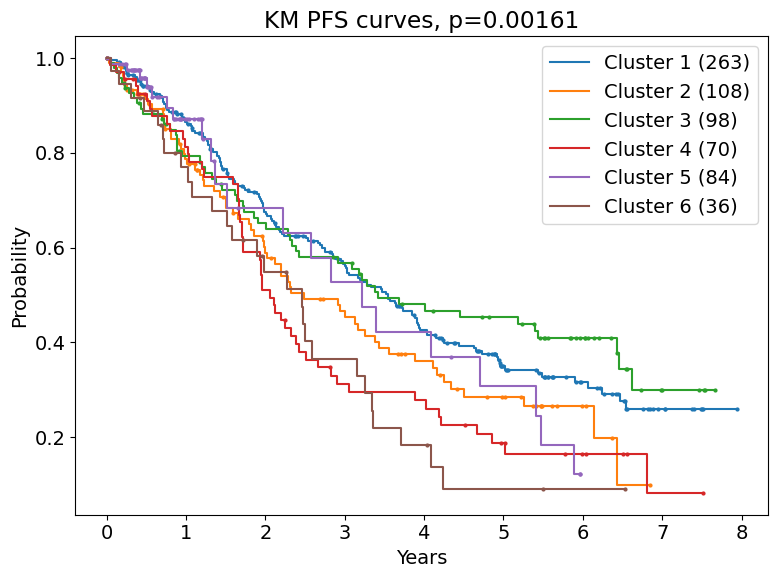

In [28]:
print(np.unique(labels, return_counts=True))

plt.figure(figsize=(8, 6))
ax = plt.subplot(111)

output = multivariate_logrank_test(event_duration, labels, censorlist)
print(output.p_value)

kmf = KaplanMeierFitter()
for ncluster in range(0, number_of_clusteres): 
    kmf.fit(event_duration[labels==ncluster],\
            censorlist[labels==ncluster], label="Cluster "+str(ncluster + 1)+ " ("+ str(sum(labels==ncluster)) +")")
    
    kmf.plot_survival_function(ax=ax,  show_censors=True,\
                               censor_styles={'ms': 2, 'marker': 'o'}, ci_show=False)
    print(ncluster, kmf.median_survival_time_, ' years')
plt.title("KM PFS curves, p=" + str(np.round(output.p_value, 5)));
plt.xlabel('Years')
plt.ylabel('Probability')

plt.rcParams.update({'font.size': 14})
plt.tight_layout()
plt.savefig('RNA_PFS_results.png', dpi=300)

In [29]:
pd.DataFrame(list(zip(selected_patient_list, labels)), columns=['PatientID', 'cluster_label']).to_csv('RNA_cluster_labels.csv')

In [30]:
def examine_cluster_pairs(labels, clinical_data_df, selected_patient_list, best_cluster, worst_cluster): 
    print("Number of subjects in best cluster: ", np.sum(labels==best_cluster))
    print("Number of subjects in worst cluster: ", np.sum(labels==worst_cluster))

    age_list1 = clinical_data_df[labels==best_cluster]['age_list'].values
    age_list2 = clinical_data_df[labels==worst_cluster]['age_list'].values
    result = stats.ttest_ind(age_list1, age_list2)
    print('Age pvalue: ', result.pvalue)
    vcounts1 = clinical_data_df[labels==best_cluster]['iss_list'].value_counts()
    vcounts1 = vcounts1.sort_index()
    vcounts1 = vcounts1.values
    
    vcounts2 = clinical_data_df[labels==worst_cluster]['iss_list'].value_counts()
    vcounts2 = vcounts2.sort_index()
    vcounts2 = vcounts2.values
    # result = stats.chisquare(vcounts1, vcounts2)
    print("best_group: ",vcounts1, "worst_group: ", vcounts2)
    # print('iss stage pvalue: ', result.pvalue)

In [31]:
for n in range(0, 6): 
    vcounts2 = clinical_data_df[labels==n]['iss_list'].value_counts()
    vcounts2 = vcounts2.sort_index()
    vcounts2 = vcounts2.values
    # result = stats.chisquare(vcounts1, vcounts2)
    print("group ", str(n+1), ": ", vcounts2/np.sum(vcounts2))

group  1 :  [0.35797665 0.32684825 0.3151751 ]
group  2 :  [0.31730769 0.34615385 0.33653846]
group  3 :  [0.48421053 0.31578947 0.2       ]
group  4 :  [0.19402985 0.52238806 0.28358209]
group  5 :  [0.38554217 0.42168675 0.19277108]
group  6 :  [0.38235294 0.35294118 0.26470588]


In [32]:
vcounts2/np.sum(vcounts2)

array([0.38235294, 0.35294118, 0.26470588])

In [33]:
best_cluster=2
worst_cluster=5

In [34]:
worstcluster_inds = labels==worst_cluster
worstcluster_inds = labels*worstcluster_inds

bestcluster_inds = labels==best_cluster
bestcluster_inds = labels*bestcluster_inds

best_worst_inds = bestcluster_inds+worstcluster_inds
binary_inds = best_worst_inds > 0
output = multivariate_logrank_test(event_duration[binary_inds==True],\
                                   labels[binary_inds==True],\
                                   censorlist[binary_inds==True])
print(output.p_value)

0.00685963785410918


5 2.4657534246575343  years
2 3.4246575342465753  years


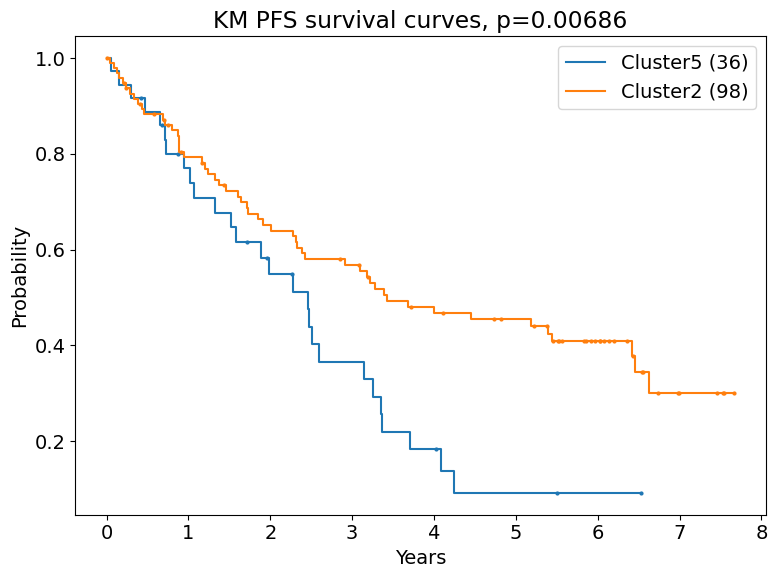

In [35]:
plt.figure(figsize=(8, 6))
ax = plt.subplot(111)
kmf = KaplanMeierFitter()
for ncluster in [worst_cluster, best_cluster]: 
    kmf.fit(event_duration[labels==ncluster],\
            censorlist[labels==ncluster], label="Cluster"+str(ncluster)+ " ("+ str(sum(labels==ncluster)) +")")
    
    kmf.plot_survival_function(ax=ax,  show_censors=True,\
                               censor_styles={'ms': 2, 'marker': 'o'}, ci_show=False)
    print(ncluster, kmf.median_survival_time_, ' years')
plt.title("KM PFS survival curves, p=" + str(np.round(output.p_value, 5)));
plt.xlabel('Years')
plt.ylabel('Probability')

plt.rcParams.update({'font.size': 14})
plt.tight_layout()




In [36]:
examine_cluster_pairs(labels, clinical_data_df, selected_patient_list, best_cluster, worst_cluster)

Number of subjects in best cluster:  98
Number of subjects in worst cluster:  36
Age pvalue:  0.7381495525082169
best_group:  [46 30 19] worst_group:  [13 12  9]


In [37]:
clinical_data_df

,index,Unnamed: 0,subjectIDlist,days_since_last_visit_list,death_flag_list,mask_list,age_list,iss_list,gender_list,therapy_list
0,0,0,MMRF_1021_1_BM_CD138pos,2909,0,1,54,1.0,2,combined bortezomib/IMIDs-based
1,1,1,MMRF_1029_1_BM_CD138pos,995,0,1,46,1.0,1,combined bortezomib/IMIDs-based
2,2,2,MMRF_1030_1_BM_CD138pos,2858,1,1,65,1.0,2,combined bortezomib/IMIDs-based
3,3,3,MMRF_1031_1_BM_CD138pos,1581,1,1,62,1.0,1,combined bortezomib/IMIDs-based
4,4,4,MMRF_1032_1_BM_CD138pos,908,1,1,76,2.0,1,Bortezomib-based
...,...,...,...,...,...,...,...,...,...,...
654,654,654,MMRF_2836_1_BM_CD138pos,161,0,1,57,2.0,1,combined IMIDs/carfilzomib-based
655,655,655,MMRF_2847_1_BM_CD138pos,163,0,1,57,3.0,1,combined IMIDs/carfilzomib-based
656,656,656,MMRF_2848_1_BM_CD138pos,198,0,1,45,2.0,2,combined IMIDs/carfilzomib-based
657,657,657,MMRF_2851_1_BM_CD138pos,189,0,1,62,1.0,2,Carfilzomib-based


In [38]:
from scipy.stats import fisher_exact

In [39]:
gene_data_df = pd.read_excel('../data/MMRF_clin_abbrev_2021_0910.xlsx')
better_subject_ids = selected_patient_list[bestcluster_inds>0]
worse_subject_ids = selected_patient_list[worstcluster_inds>0]

better_subject_ids_filt = [] 
for subjid in better_subject_ids: 
    better_subject_ids_filt.append(subjid[0:-9])
    
worse_subject_ids_filt = [] 
for subjid in worse_subject_ids: 
    worse_subject_ids_filt.append(subjid[0:-9])
    
better_df = gene_data_df[gene_data_df['sample'].isin(better_subject_ids_filt)]
worse_df = gene_data_df[gene_data_df['sample'].isin(worse_subject_ids_filt)]

columns = ['HRD', 't_MMSET', 't_CCND1', 'any_MAF', 't_MYC', 'chromothripsis_code']

tricol = ['gain1q21', 'TP53sum']

for genecol in columns: 
    print(genecol)
    print(better_df[genecol].value_counts().sort_index())
    print(worse_df[genecol].value_counts().sort_index())
    
        
    array1 = better_df[genecol].value_counts().sort_index()
    array2 = worse_df[genecol].value_counts().sort_index()
    
    
    if len(array1) == 1: 
        a1 = np.zeros((2,))
        if array1.index[0] == 0: 
            a1[0] = array1[0]
        if array1.index[0] == 1: 
            a1[1] = array1[0]
        array1 = a1
    else: 
        array1 = array1.values
        
    if len(array2) == 1: 
        a2 = np.zeros((2,))
        if array2.index[0] == 0: 
            a2[0] = array2[0]
        if array2.index[0] == 1: 
            a2[1] = array1[0]
        array2 = a2
    else: 
        array2 = array2.values
        
        
        
    print(array1)
    print(array2)
    
    
    table = np.array([array1, array2])                  
    oddsr, p  = stats.fisher_exact(table)                
#         result = stats.chisquare(better_df[genecol].value_counts().sort_index().values,\
#                              worse_df[genecol].value_counts().sort_index().values)
    
    print(p)
 
    print("----------------")
    
    

for genecol in tricol: 
    print(genecol)
    print(better_df[genecol].value_counts().sort_index())
    print(worse_df[genecol].value_counts().sort_index())
    print("----------------")



HRD
0.0    73
1.0     9
Name: HRD, dtype: int64
0.0    25
1.0     5
Name: HRD, dtype: int64
[73  9]
[25  5]
0.5193653585720854
----------------
t_MMSET
0.0    85
Name: t_MMSET, dtype: int64
0.0    30
1.0     2
Name: t_MMSET, dtype: int64
[85.  0.]
[30  2]
0.07309165929855585
----------------
t_CCND1
0.0     8
1.0    77
Name: t_CCND1, dtype: int64
0.0    32
Name: t_CCND1, dtype: int64
[ 8 77]
[32.  0.]
1.4359648530416848e-21
----------------
any_MAF
0    85
Name: any_MAF, dtype: int64
0     6
1    26
Name: any_MAF, dtype: int64
[85.  0.]
[ 6 26]
1.2446086084800459e-20
----------------
t_MYC
0.0    81
1.0     4
Name: t_MYC, dtype: int64
0.0    28
1.0     4
Name: t_MYC, dtype: int64
[81  4]
[28  4]
0.21169028575828205
----------------
chromothripsis_code
0    78
1     7
Name: chromothripsis_code, dtype: int64
0    18
1    14
Name: chromothripsis_code, dtype: int64
[78  7]
[18 14]
3.312169675840342e-05
----------------
gain1q21
0.0    72
1.0    10
Name: gain1q21, dtype: int64
0.0    12
1.0

In [40]:
len(selected_patient_list) 

659

In [41]:
selected_patient_list_medium = [] 
for subjid in selected_patient_list: 
    selected_patient_list_medium.append(subjid[0:-9])

In [42]:
selected_patient_list_medium

['MMRF_1021_1_BM',
 'MMRF_1029_1_BM',
 'MMRF_1030_1_BM',
 'MMRF_1031_1_BM',
 'MMRF_1032_1_BM',
 'MMRF_1033_1_BM',
 'MMRF_1037_1_BM',
 'MMRF_1048_1_BM',
 'MMRF_1068_1_BM',
 'MMRF_1073_1_BM',
 'MMRF_1077_1_BM',
 'MMRF_1079_1_BM',
 'MMRF_1082_1_BM',
 'MMRF_1089_1_BM',
 'MMRF_1092_1_BM',
 'MMRF_1098_1_BM',
 'MMRF_1108_1_BM',
 'MMRF_1148_1_BM',
 'MMRF_1164_1_BM',
 'MMRF_1167_1_BM',
 'MMRF_1169_1_BM',
 'MMRF_1171_1_BM',
 'MMRF_1178_1_BM',
 'MMRF_1180_1_BM',
 'MMRF_1185_1_BM',
 'MMRF_1188_1_BM',
 'MMRF_1189_1_BM',
 'MMRF_1195_1_BM',
 'MMRF_1202_1_BM',
 'MMRF_1210_1_BM',
 'MMRF_1216_1_BM',
 'MMRF_1231_1_BM',
 'MMRF_1250_1_BM',
 'MMRF_1251_1_BM',
 'MMRF_1267_1_BM',
 'MMRF_1269_1_BM',
 'MMRF_1270_1_BM',
 'MMRF_1274_1_BM',
 'MMRF_1284_1_BM',
 'MMRF_1286_1_BM',
 'MMRF_1293_1_BM',
 'MMRF_1300_1_BM',
 'MMRF_1309_1_BM',
 'MMRF_1318_1_BM',
 'MMRF_1323_1_BM',
 'MMRF_1324_1_BM',
 'MMRF_1325_1_BM',
 'MMRF_1327_1_BM',
 'MMRF_1328_1_BM',
 'MMRF_1331_1_BM',
 'MMRF_1338_1_BM',
 'MMRF_1342_1_BM',
 'MMRF_1344_

In [43]:
gene_translocation_df = gene_data_df[gene_data_df['sample'].isin(selected_patient_list_medium)]

In [44]:
gene_translocation_df.shape

(579, 16)

In [45]:
gene_translocation_df

,sample,age,gender,pfs_code,pfs_time,os_code,os_time,HRD,gain1q21,ampMYC,t_CCND1,t_MMSET,any_MAF,t_MYC,TP53sum,chromothripsis_code
1,MMRF_1021_1_BM,54.0,FEMALE,1.0,532.0,0.0,2135.0,0.0,1.0,0.0,0.0,1.0,0,0.0,0.0,0
2,MMRF_1029_1_BM,46.0,MALE,0.0,995.0,0.0,995.0,1.0,0.0,0.0,0.0,0.0,0,0.0,NaN,0
3,MMRF_1030_1_BM,65.0,FEMALE,1.0,1983.0,0.0,2143.0,1.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0
4,MMRF_1031_1_BM,62.0,MALE,1.0,1329.0,1.0,1670.0,1.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0
5,MMRF_1032_1_BM,76.0,MALE,1.0,438.0,1.0,934.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,MMRF_2746_1_BM,NaN,NaN,0.0,171.0,0.0,171.0,0.0,1.0,0.0,0.0,1.0,0,0.0,0.0,0
743,MMRF_2750_1_BM,NaN,NaN,0.0,330.0,0.0,330.0,0.0,0.0,0.0,1.0,0.0,0,0.0,NaN,0
744,MMRF_2751_1_BM,NaN,NaN,0.0,142.0,0.0,142.0,0.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0
747,MMRF_2754_1_BM,NaN,NaN,NaN,1.0,1.0,8.0,0.0,1.0,0.0,1.0,0.0,0,0.0,0.0,0


# Examine each cluster 

In [48]:
gene_data_df = pd.read_excel('../data/MMRF_clin_abbrev_2021_0910.xlsx')
columns = ['HRD', 't_MMSET', 't_CCND1', 'any_MAF', 't_MYC', 'chromothripsis_code']
output_df = pd.DataFrame(columns=columns + tricol, index=list(range(0, number_of_clusteres)))

for cluster_n in range(0, number_of_clusteres):
#     print("~~~~~~~~~~~~~~~~ CLUSTER: ", cluster_n)
    cluster_inds = labels==cluster_n
    better_subject_ids = selected_patient_list[cluster_inds>0]

    better_subject_ids_filt = [] 
    for subjid in better_subject_ids: 
        better_subject_ids_filt.append(subjid[0:-9])

    better_df = gene_data_df[gene_data_df['sample'].isin(better_subject_ids_filt)]

    tricol = ['gain1q21', 'TP53sum']

    for genecol in columns: 
#         print(genecol)
#         print(better_df[genecol].value_counts().sort_index())
        
        datavalues = better_df[genecol].value_counts().sort_index().values
        total_entries = np.sum(datavalues) 
        
        if len(datavalues) == 2: 
            outputstr = str(datavalues[1]) + "/" + str(total_entries)       
        else: 
            outputstr = str(0) + "/" + str(total_entries)  

        output_df[genecol][cluster_n] = outputstr
        

    for genecol in tricol: 
#         print(genecol)
#         print(better_df[genecol].value_counts().sort_index())
        
        datavalues = better_df[genecol].value_counts().sort_index()
        total_entries = np.sum(datavalues) 
        
        if len(datavalues.index.values) == 3: 
            datavalues = datavalues.values
            outputstr = '(0): ' + str(datavalues[0]) + '; (1): ' + str(datavalues[1]) + '; (2): ' + str(datavalues[2])
        
        elif np.sum(datavalues.index.values == [0, 1]) == 2: 
            datavalues = datavalues.values
            outputstr = '(0): ' + str(datavalues[0]) + '; (1): ' + str(datavalues[1])
        elif np.sum(datavalues.index.values == [0, 2]) == 2:
            datavalues = datavalues.values
            outputstr = '(0): ' + str(datavalues[0]) + '; (2): ' + str(datavalues[1])
        elif len(datavalues.index.values) == 1:
            outputstr = '(0): ' + str(total_entries)
    
        output_df[genecol][cluster_n] = outputstr
        


In [49]:
output_df

,HRD,t_MMSET,t_CCND1,any_MAF,t_MYC,chromothripsis_code,gain1q21,TP53sum
0,197/229,0/247,3/247,1/247,61/247,62/247,(0): 154; (1): 66; (2): 9,(0): 178; (1): 24; (2): 5
1,62/93,2/98,19/98,2/98,13/98,21/98,(0): 70; (1): 21; (2): 2,(0): 69; (1): 9; (2): 3
2,9/82,0/85,77/85,0/85,4/85,7/85,(0): 72; (1): 10,(0): 60; (1): 5; (2): 4
3,12/63,64/65,0/65,2/65,7/65,26/65,(0): 33; (1): 18; (2): 12,(0): 49; (1): 7; (2): 3
4,28/46,11/52,11/52,3/52,7/52,17/52,(0): 30; (1): 15; (2): 1,(0): 40; (1): 4; (2): 1
5,5/30,2/32,0/32,26/32,4/32,14/32,(0): 12; (1): 12; (2): 6,(0): 22; (1): 4; (2): 2


In [50]:
gene_cluster_df = output_df

In [51]:
foo = output_df.T

In [52]:
foo[[2, 5]]

,2,5
HRD,9/82,5/30
t_MMSET,0/85,2/32
t_CCND1,77/85,0/32
any_MAF,0/85,26/32
t_MYC,4/85,4/32
chromothripsis_code,7/85,14/32
gain1q21,(0): 72; (1): 10,(0): 12; (1): 12; (2): 6
TP53sum,(0): 60; (1): 5; (2): 4,(0): 22; (1): 4; (2): 2


In [53]:
secondary_dataset_df = pd.read_excel('../data/MMRF_clin_IA13_to_Anish.xlsx')
gene_cols_list = secondary_dataset_df.columns[9:]
# gene_cols_list.append('APOBEC_code')
output_df = pd.DataFrame(columns=gene_cols_list, index=list(range(0, number_of_clusteres)))

for cluster_n in range(0, number_of_clusteres):
    cluster_inds = labels==cluster_n
    better_subject_ids = selected_patient_list[cluster_inds>0]

    better_subject_ids_filt = [] 
    for subjid in better_subject_ids: 
        better_subject_ids_filt.append(subjid[0:-9])

    better_df = secondary_dataset_df[secondary_dataset_df['sample'].isin(better_subject_ids_filt)]

    for genecol in gene_cols_list: 
        if genecol in ['TPsum', 'apobec', 'any_MAF']: 
            continue
#         print(genecol)
#         print(better_df[genecol].value_counts().sort_index())
        
        datavalues = better_df[genecol].value_counts().sort_index().values
        total_entries = np.sum(datavalues) 
        
        if len(datavalues) == 2: 
            outputstr = str(datavalues[1]) + "/" + str(total_entries)       
        else: 
            outputstr = str(0) + "/" + str(total_entries)  

        output_df[genecol][cluster_n] = outputstr
        

In [54]:
secondary_dataset_df

,sample,chromothripsis_code,chromothripsis,age,gender,pfs_code,pfs_time,os_code,os_time,ABCF1,...,t_CCND1,t_MMSET,t_MAFB,t_MAF,t_CCND3,t_MYC,TPsum,apobec,APOBEC_code,any_MAF
0,MMRF_1016_1_BM,1,23,56.0,MALE,0.0,673.0,1.0,692.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
1,MMRF_1021_1_BM,0,0,54.0,FEMALE,1.0,532.0,0.0,2135.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.052916,0.0,0
2,MMRF_1029_1_BM,0,0,46.0,MALE,0.0,995.0,0.0,995.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.059776,0.0,0
3,MMRF_1030_1_BM,0,0,65.0,FEMALE,1.0,1983.0,0.0,2143.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.088501,0.0,0
4,MMRF_1031_1_BM,0,0,62.0,MALE,1.0,1329.0,1.0,1670.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.039202,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747,MMRF_2754_1_BM,0,0,NaN,NaN,NaN,1.0,1.0,8.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
748,MMRF_2755_1_BM,0,0,NaN,NaN,0.0,152.0,0.0,152.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0
749,MMRF_2756_1_BM,0,0,NaN,NaN,0.0,344.0,0.0,344.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.000000,0.0,0
750,MMRF_2757_1_BM,0,0,NaN,NaN,0.0,359.0,0.0,359.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0


In [55]:
secondary_dataset_df.columns

Index(['sample', 'chromothripsis_code', 'chromothripsis', 'age', 'gender',
       'pfs_code', 'pfs_time', 'os_code', 'os_time', 'ABCF1', 'ACTG1', 'ARID2',
       'BCL7A', 'BHLHE41', 'BRAF', 'BTG1', 'CCND1', 'CYLD', 'DIS3', 'DTX1',
       'DUSP2', 'EGR1', 'FAM46C', 'FGFR3', 'FUBP1', 'HIST1H1B', 'HIST1H1D',
       'HIST1H1E', 'IGLL5', 'IRF1', 'IRF4', 'KLHL6', 'KMT2B', 'KRAS', 'LCE1D',
       'LTB', 'MAX', 'NFKB2', 'NFKBIA', 'NRAS', 'PABPC1', 'PIM1', 'POT1',
       'PRDM1', 'PRKD2', 'PTPN11', 'RASA2', 'RB1', 'RPL10', 'RPL5', 'RPRD1B',
       'RPS3A', 'SAMHD1', 'SETD2', 'SP140', 'TBC1D29', 'TCL1A', 'TGDS', 'TP53',
       'TRAF2', 'TRAF3', 'ZNF292', 'del4p15', 'del12p13', 'del12q21',
       'gain1q21', 'del8p22', 'gain6p22', 'del20p12', 'ampMYC', 'delRB1',
       'del6q', 'delCDKN2C', 'delTP53', 'delFAM46c', 'delCYLD', 'delTRAF3',
       'delTRAF2', 'del13q34', 'del14q23', 'HRD', 't_CCND1', 't_MMSET',
       't_MAFB', 't_MAF', 't_CCND3', 't_MYC', 'TPsum', 'apobec', 'APOBEC_code',
       'an

In [56]:
output_df['delTP53']

0    30/229
1     11/93
2      8/82
3     10/63
4      5/46
5      5/30
Name: delTP53, dtype: object

In [57]:
secondary_dataset_df['delTP53'].value_counts()

0.0    626
1.0     83
Name: delTP53, dtype: int64

In [58]:
secondary_dataset_df.shape

(752, 91)

In [59]:
output_df['APOBEC_code']

0    4/247
1     7/97
2     2/83
3     1/65
4     3/52
5    23/32
Name: APOBEC_code, dtype: object

In [60]:
gene_cluster_df.insert(8, 'APOBEC_code', output_df['APOBEC_code'])

In [61]:
gene_cluster_df

,HRD,t_MMSET,t_CCND1,any_MAF,t_MYC,chromothripsis_code,gain1q21,TP53sum,APOBEC_code
0,197/229,0/247,3/247,1/247,61/247,62/247,(0): 154; (1): 66; (2): 9,(0): 178; (1): 24; (2): 5,4/247
1,62/93,2/98,19/98,2/98,13/98,21/98,(0): 70; (1): 21; (2): 2,(0): 69; (1): 9; (2): 3,7/97
2,9/82,0/85,77/85,0/85,4/85,7/85,(0): 72; (1): 10,(0): 60; (1): 5; (2): 4,2/83
3,12/63,64/65,0/65,2/65,7/65,26/65,(0): 33; (1): 18; (2): 12,(0): 49; (1): 7; (2): 3,1/65
4,28/46,11/52,11/52,3/52,7/52,17/52,(0): 30; (1): 15; (2): 1,(0): 40; (1): 4; (2): 1,3/52
5,5/30,2/32,0/32,26/32,4/32,14/32,(0): 12; (1): 12; (2): 6,(0): 22; (1): 4; (2): 2,23/32


In [62]:
gene_cluster_df.T.to_csv('rna_clustering_genomic_factors.csv')

In [63]:
secondary_dataset_df2 = secondary_dataset_df[secondary_dataset_df['sample'].isin(selected_patient_list_medium)]

In [64]:
secondary_dataset_df2 = secondary_dataset_df2[['sample', 'HRD', 't_MMSET', 't_CCND1', 'any_MAF', 't_MYC', 'chromothripsis_code', 'APOBEC_code']]

In [65]:
selected_patient_list_medium = np.array(selected_patient_list_medium)

In [66]:
sorted_subject_names = [] 

for cluster_n in range(0, number_of_clusteres):
#     print("~~~~~~~~~~~~~~~~ CLUSTER: ", cluster_n)
    cluster_inds = labels==cluster_n
    better_subject_ids = selected_patient_list_medium[cluster_inds>0]
    sorted_subject_names.append(better_subject_ids) 
    print(len(better_subject_ids))

263
108
98
70
84
36


In [67]:
sorted_subject_names = np.concatenate(sorted_subject_names) 

In [68]:
sorted_subject_names[-8:-1]

array(['MMRF_2269_1_BM', 'MMRF_2306_1_BM', 'MMRF_2373_1_BM',
       'MMRF_2380_1_BM', 'MMRF_2459_1_BM', 'MMRF_2739_1_BM',
       'MMRF_2762_1_BM'], dtype='<U14')

In [69]:
# secondary_dataset_df2 = secondary_dataset_df2[secondary_dataset_df2['sample'].isin(sorted_subject_names)]

In [70]:
secondary_dataset_df2 = secondary_dataset_df2.set_index('sample')

In [71]:
secondary_dataset_df2 = secondary_dataset_df2.reindex(sorted_subject_names) 

In [72]:

# HRD = hyperdiploid
# t_MMSET = t(4;14)
# t_CCND1 = t(11;14)
# any_MAF = translocation involving MAF or MAF-B
# t_MYC = translocation involving MYC
# TP53sum =  2 if biallelic (deletion + mutation), 1 if either

In [73]:
renamedict = {'HRD':'Hyperdiploidy', 't_MMSET':'t(4;14)', 't_CCND1':'t(11;14)',\
              'any_MAF':'Translocation involving MAF/MAFA/MAFB',\
              't_MYC':'Translocation involving MYC', \
              'chromothripsis_code': 'Chromothripsis',\
              'APOBEC_code':'Hyper-APOBEC'}

In [74]:
secondary_dataset_df2 = secondary_dataset_df2.rename(columns=renamedict)

In [75]:
secondary_dataset_df2

,Hyperdiploidy,t(4;14),t(11;14),Translocation involving MAF/MAFA/MAFB,Translocation involving MYC,Chromothripsis,Hyper-APOBEC
sample,,,,,,,
MMRF_1030_1_BM,1.0,0.0,0.0,0.0,1.0,0.0,0.0
MMRF_1031_1_BM,1.0,0.0,0.0,0.0,0.0,0.0,0.0
MMRF_1033_1_BM,NaN,0.0,0.0,0.0,0.0,0.0,1.0
MMRF_1037_1_BM,1.0,0.0,0.0,0.0,0.0,0.0,0.0
MMRF_1068_1_BM,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...
MMRF_2380_1_BM,0.0,0.0,0.0,1.0,1.0,1.0,0.0
MMRF_2459_1_BM,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MMRF_2739_1_BM,0.0,0.0,0.0,1.0,0.0,1.0,1.0


In [76]:
import seaborn as sns

In [77]:
foo = secondary_dataset_df2

In [78]:
foo = foo.dropna()

In [79]:
foo = foo.T

In [80]:
foo.shape

(7, 540)

In [81]:
263
108
98
70
84
36

36

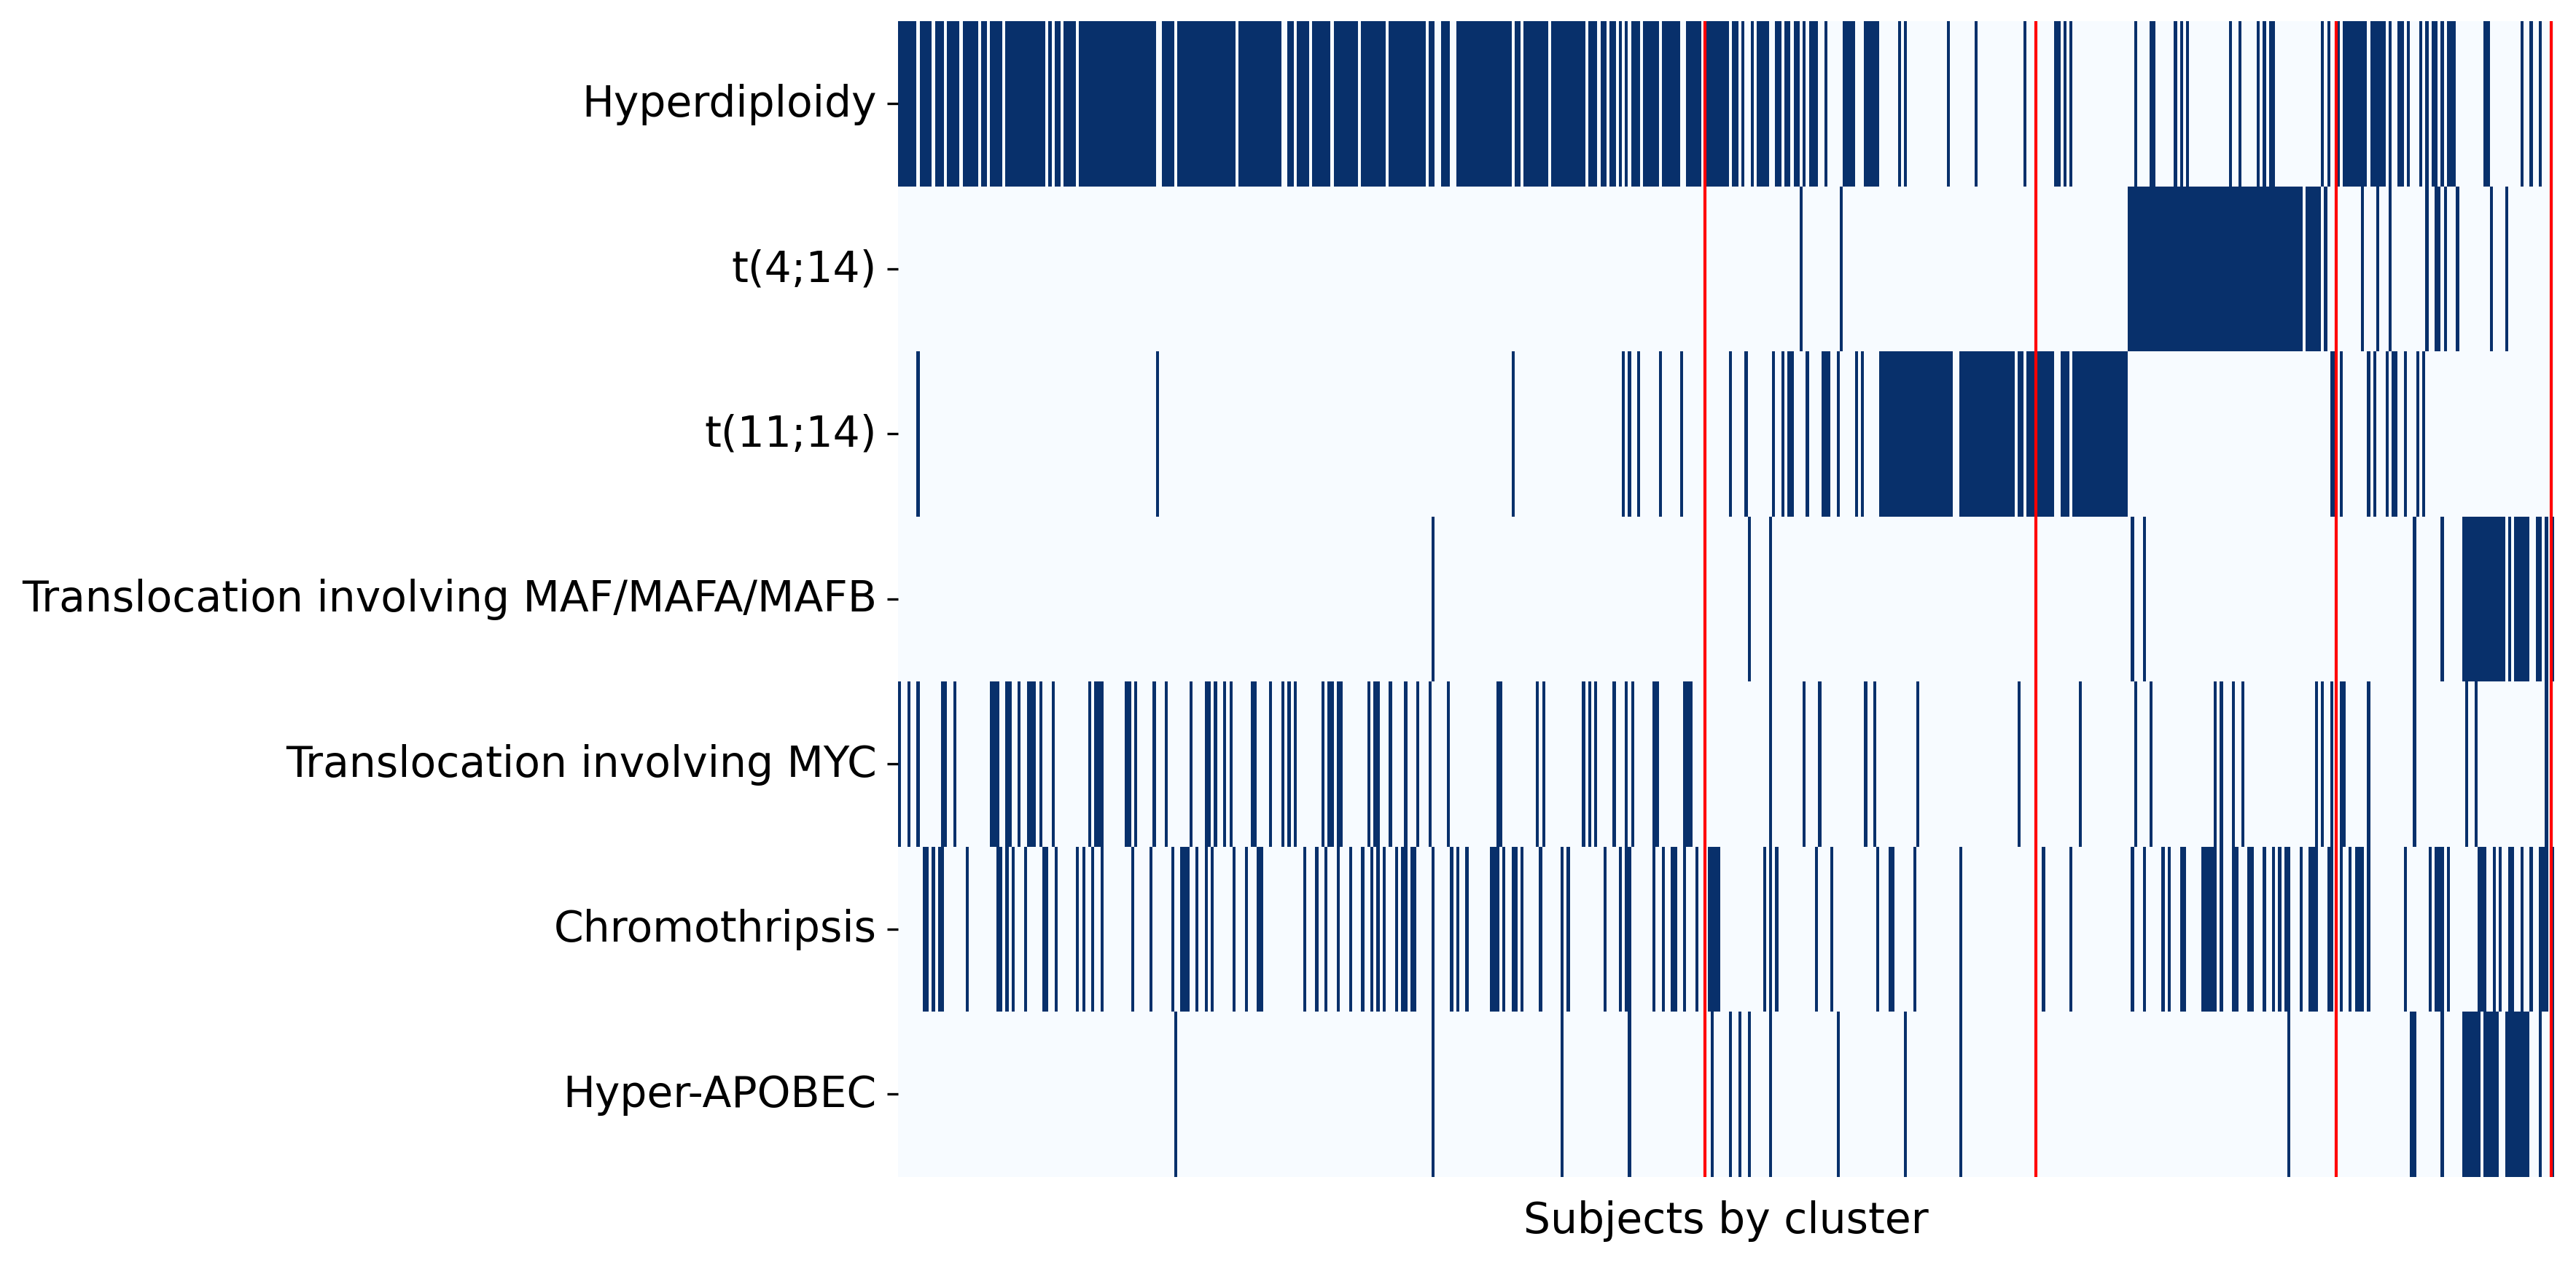

In [82]:
plt.figure(figsize=(12,6), dpi=300)
sns.heatmap(foo, annot=False, fmt='g', cmap='Blues', cbar=False, xticklabels=False)
# plt.title('Fraction of subjects within a cluster with a given attribute') 
# plt.ylabel('')
plt.axvline(x=263, linewidth=1, color="r")
plt.axvline(x=263+108, linewidth=1, color="r")
plt.axvline(x=263+108+98, linewidth=1, color="r")
plt.axvline(x=263+108+98+70, linewidth=1, color="r")
plt.axvline(x=263+108+98+70+84, linewidth=1, color="r")

plt.xlabel('Subjects by cluster') 
plt.tight_layout()
plt.savefig('cluster_heatmap4.png')

### Output data for random forest

In [83]:
len(selected_patient_list) 

659

In [84]:
selected_patient_list_filt = [] 
for subjid in selected_patient_list: 
    selected_patient_list_filt.append(subjid[0:-9])

In [85]:
modeling_data_df = secondary_dataset_df[secondary_dataset_df['sample'].isin(selected_patient_list_filt)]

In [86]:
len(labels) 

659

In [87]:
rf_sample_ids = modeling_data_df['sample']

In [88]:
modeling_data_df.insert(2, 'cluster', np.nan)

In [89]:
modeling_data_df = modeling_data_df.reset_index()

In [90]:
selected_patient_list_filt = np.array(selected_patient_list_filt)

In [91]:
for n in range(0, len(modeling_data_df)): 
    location = np.argwhere(selected_patient_list_filt==modeling_data_df['sample'][n])
    location = location[0][0]
    modeling_data_df['cluster'][n] = labels[location]

/var/folders/3j/g7yn2lsj77bgd5fs3b35rlmh0000gn/T/ipykernel_76652/2798674462.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modeling_data_df['cluster'][n] = labels[location]


In [92]:
modeling_data_df.to_csv("modelingdata.csv")

## best cluster / worst cluster

In [93]:
best_cluster_labels1 = labels==0
best_cluster_labels2 = labels==2
best_cluster_labels = best_cluster_labels2 + best_cluster_labels1
print("best total:", np.sum(best_cluster_labels))

worst_cluster_labels5 = labels==5
worst_cluster_labels3 = labels==3
worst_cluster_labels = worst_cluster_labels3 + worst_cluster_labels5
print("worst total: ", np.sum(worst_cluster_labels))

best total: 361
worst total:  106


In [94]:
best_worst_inds = worst_cluster_labels+best_cluster_labels
binary_inds = best_worst_inds > 0

labels2 = np.zeros(len(labels),)
labels2[worst_cluster_labels==True] = 1
labels2[best_cluster_labels==True] = 2

output = multivariate_logrank_test(event_duration[binary_inds==True],\
                                   labels2[binary_inds==True],\
                                   censorlist[binary_inds==True])
print(output.p_value)

3.483839715383463e-05


In [95]:
import scipy

In [96]:
scipy.io.savemat('rna_clustering_results.mat', {'labels2':labels2,\
                     'overall_curvature':overall_curvature,\
                     'patient_list':patient_list[patients_mask],\
                        'patients_mask':patients_mask})

In [97]:
len(patient_list[patients_mask]) 

659

In [98]:
len(labels2)

659

In [99]:
overall_curvature.shape

(33695, 659)

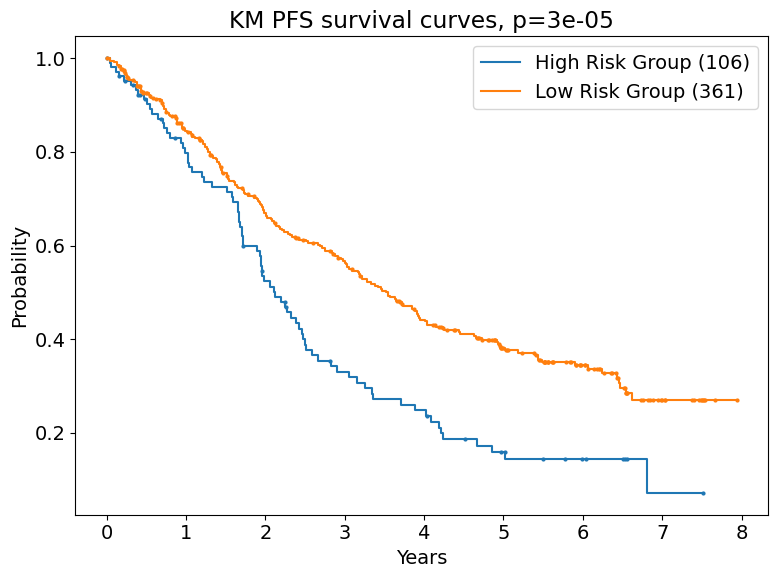

In [100]:
label_list = ["High Risk Group", "Low Risk Group"]
plt.figure(figsize=(8, 6))
ax = plt.subplot(111)
kmf = KaplanMeierFitter()
for ncluster in [1, 2]: 
    kmf.fit(event_duration[labels2==ncluster],\
            censorlist[labels2==ncluster],\
            label = label_list[ncluster-1]+ " ("+ str(sum(labels2==ncluster)) +")")
    
    kmf.plot_survival_function(ax=ax,  show_censors=True,\
                               censor_styles={'ms': 2, 'marker': 'o'}, ci_show=False)

plt.title("KM PFS survival curves, p=" + str(np.round(output.p_value, 5)));
plt.xlabel('Years')
plt.ylabel('Probability')

plt.rcParams.update({'font.size': 14})
plt.tight_layout()


plt.savefig('RNA_PFS_bestworst_results.png', dpi=300)

In [101]:
examine_cluster_pairs(labels2, clinical_data_df, selected_patient_list, 2, 1)

Number of subjects in best cluster:  361
Number of subjects in worst cluster:  106
Age pvalue:  0.1564052330298206
best_group:  [138 114 100] worst_group:  [26 47 28]


In [102]:
low_risk_subject_list = selected_patient_list[labels2==2]

In [103]:
low_risk_clinical_data = clinical_data_df[clinical_data_df['subjectIDlist'].isin(low_risk_subject_list)]

In [104]:
# low_risk_clinical_data = low_risk_clinical_data[low_risk_clinical_data['iss_list'].isin([3])]

In [105]:
clinical_data_df.shape

(659, 10)

In [106]:
low_risk_clinical_data.shape

(361, 10)

In [107]:
foo = low_risk_clinical_data['subjectIDlist'].values

shortsubjectlist = [] 
for n in foo: 
    shortsubjectlist.append(n[0:14])
shortsubjectlist = np.array(shortsubjectlist)

In [108]:
selected_data_df = gene_data_df[gene_data_df['sample'].isin(shortsubjectlist)]

In [109]:
selected_data_df['t_CCND1'].value_counts()

0.0    252
1.0     80
Name: t_CCND1, dtype: int64

In [110]:
selected_data_df['t_MMSET'].value_counts()


0.0    332
Name: t_MMSET, dtype: int64

In [111]:
selected_data_df['gain1q21'].value_counts()


0.0    226
1.0     76
2.0      9
Name: gain1q21, dtype: int64

In [112]:
selected_data_df['any_MAF'].value_counts()


0    331
1      1
Name: any_MAF, dtype: int64

In [113]:
selected_data_df['t_MYC'].value_counts()


0.0    267
1.0     65
Name: t_MYC, dtype: int64

In [114]:
len(shortsubjectlist)

361

In [115]:
stage3data = secondary_dataset_df[secondary_dataset_df['sample'].isin(shortsubjectlist)]

In [116]:
stage3data.columns

Index(['sample', 'chromothripsis_code', 'chromothripsis', 'age', 'gender',
       'pfs_code', 'pfs_time', 'os_code', 'os_time', 'ABCF1', 'ACTG1', 'ARID2',
       'BCL7A', 'BHLHE41', 'BRAF', 'BTG1', 'CCND1', 'CYLD', 'DIS3', 'DTX1',
       'DUSP2', 'EGR1', 'FAM46C', 'FGFR3', 'FUBP1', 'HIST1H1B', 'HIST1H1D',
       'HIST1H1E', 'IGLL5', 'IRF1', 'IRF4', 'KLHL6', 'KMT2B', 'KRAS', 'LCE1D',
       'LTB', 'MAX', 'NFKB2', 'NFKBIA', 'NRAS', 'PABPC1', 'PIM1', 'POT1',
       'PRDM1', 'PRKD2', 'PTPN11', 'RASA2', 'RB1', 'RPL10', 'RPL5', 'RPRD1B',
       'RPS3A', 'SAMHD1', 'SETD2', 'SP140', 'TBC1D29', 'TCL1A', 'TGDS', 'TP53',
       'TRAF2', 'TRAF3', 'ZNF292', 'del4p15', 'del12p13', 'del12q21',
       'gain1q21', 'del8p22', 'gain6p22', 'del20p12', 'ampMYC', 'delRB1',
       'del6q', 'delCDKN2C', 'delTP53', 'delFAM46c', 'delCYLD', 'delTRAF3',
       'delTRAF2', 'del13q34', 'del14q23', 'HRD', 't_CCND1', 't_MMSET',
       't_MAFB', 't_MAF', 't_CCND3', 't_MYC', 'TPsum', 'apobec', 'APOBEC_code',
       'an

In [117]:
stage3data['gain1q21'].value_counts()

0.0    226
1.0     76
2.0      9
Name: gain1q21, dtype: int64

In [118]:
stage3data['t_MMSET'].value_counts()

0.0    332
Name: t_MMSET, dtype: int64

In [119]:
stage3data['t_MAF'].value_counts()

0.0    332
Name: t_MAF, dtype: int64

In [120]:
stage3data['delTP53'].value_counts()

0.0    273
1.0     38
Name: delTP53, dtype: int64

In [121]:
stage3data['gain1q21'].value_counts()

0.0    226
1.0     76
2.0      9
Name: gain1q21, dtype: int64

In [122]:
stage3data['gain1q21'].value_counts()

0.0    226
1.0     76
2.0      9
Name: gain1q21, dtype: int64

In [123]:
gain1q21 = stage3data['gain1q21'].values
delTP53 = stage3data['delTP53'].values

In [124]:
bothdel53Andgain1q = delTP53*gain1q21

In [125]:
pd.DataFrame(bothdel53Andgain1q).value_counts()

0.0    301
1.0      7
2.0      3
dtype: int64

In [126]:
bothdel53ORgain1q = delTP53+gain1q21

In [127]:
pd.DataFrame(bothdel53ORgain1q).value_counts()

0.0    198
1.0     97
2.0     13
3.0      3
dtype: int64

In [128]:
(97+13+3) / len(bothdel53ORgain1q)

0.34036144578313254

In [129]:
stage3data.shape

(332, 91)

In [161]:
gene_data_df = pd.read_excel('../data/MMRF_clin_abbrev_2021_0910.xlsx')
better_subject_ids = selected_patient_list[best_cluster_labels>0]
worse_subject_ids = selected_patient_list[worst_cluster_labels>0]

better_subject_ids_filt = [] 
for subjid in better_subject_ids: 
    better_subject_ids_filt.append(subjid[0:-9])
    
worse_subject_ids_filt = [] 
for subjid in worse_subject_ids: 
    worse_subject_ids_filt.append(subjid[0:-9])
    
better_df = gene_data_df[gene_data_df['sample'].isin(better_subject_ids_filt)]
worse_df = gene_data_df[gene_data_df['sample'].isin(worse_subject_ids_filt)]

columns = ['HRD', 't_MMSET', 't_CCND1', 'any_MAF', 't_MYC', 'chromothripsis_code']

tricol = ['gain1q21', 'TP53sum']

for genecol in columns: 
    print(genecol)
    print(better_df[genecol].value_counts().sort_index())
    print(worse_df[genecol].value_counts().sort_index())
    
    array1 = better_df[genecol].value_counts().sort_index()
    array2 = worse_df[genecol].value_counts().sort_index()
    
    if len(array1) == 1: 
        a1 = np.zeros((2,))
        if array1.index[0] == 0: 
            a1[0] = array1[0]
        if array1.index[0] == 1: 
            a1[1] = array1[0]
        array1 = a1
    else: 
        array1 = array1.values
        
    if len(array2) == 1: 
        a2 = np.zeros((2,))
        if array2.index[0] == 0: 
            a2[0] = array2[0]
        if array2.index[0] == 1: 
            a2[1] = array1[0]
        array2 = a2
    else: 
        array2 = array2.values
                
    print(array1)
    print(array2)
    
    table = np.array([array1, array2])                  
    oddsr, p  = stats.fisher_exact(table)                

    print(p)
    print("----------------")
    
for genecol in tricol: 
    print(genecol)
    print(better_df[genecol].value_counts().sort_index())
    print(worse_df[genecol].value_counts().sort_index())
    print("----------------")

HRD
0.0    105
1.0    206
Name: HRD, dtype: int64
0.0    76
1.0    17
Name: HRD, dtype: int64
[105 206]
[76 17]
1.323401141314244e-16
----------------
t_MMSET
0.0    332
Name: t_MMSET, dtype: int64
0.0    31
1.0    66
Name: t_MMSET, dtype: int64
[332.   0.]
[31 66]
4.142122770882599e-54
----------------
t_CCND1
0.0    252
1.0     80
Name: t_CCND1, dtype: int64
0.0    97
Name: t_CCND1, dtype: int64
[252  80]
[97.  0.]
1.4141135452743124e-10
----------------
any_MAF
0    331
1      1
Name: any_MAF, dtype: int64
0    69
1    28
Name: any_MAF, dtype: int64
[331   1]
[69 28]
6.540913551767512e-19
----------------
t_MYC
0.0    267
1.0     65
Name: t_MYC, dtype: int64
0.0    86
1.0    11
Name: t_MYC, dtype: int64
[267  65]
[86 11]
0.06974643430803618
----------------
chromothripsis_code
0    263
1     69
Name: chromothripsis_code, dtype: int64
0    57
1    40
Name: chromothripsis_code, dtype: int64
[263  69]
[57 40]
0.00010087984612362966
----------------
gain1q21
0.0    226
1.0     76
2.0   

In [164]:
table = np.array([[226, 76, 9], [45, 30, 18]])                  
stat, p, dof, expected = chi2_contingency(table)

In [165]:
p

9.294446059025976e-09

In [167]:
table = np.array([[238, 29, 9], [71, 11, 5]])                  
stat, p, dof, expected = chi2_contingency(table)

In [168]:
p

0.47230371089399703

In [169]:
gene_data_df.columns

Index(['sample', 'age', 'gender', 'pfs_code', 'pfs_time', 'os_code', 'os_time',
       'HRD', 'gain1q21', 'ampMYC', 't_CCND1', 't_MMSET', 'any_MAF', 't_MYC',
       'TP53sum', 'chromothripsis_code'],
      dtype='object')

In [170]:
gene_data_df = pd.read_excel('../data/MMRF_clin_abbrev_2021_0910.xlsx')
columns = ['HRD', 't_MMSET', 't_CCND1', 'any_MAF', 't_MYC', 'chromothripsis_code']
tricol = ['gain1q21', 'TP53sum']
number_of_clusteres=3
output_df = pd.DataFrame(columns=columns + tricol, index=list(range(0, number_of_clusteres)))

for cluster_n in range(1, 3):
    cluster_inds = labels2==cluster_n
    better_subject_ids = selected_patient_list[cluster_inds>0]
    better_subject_ids_filt = [] 
    for subjid in better_subject_ids: 
        better_subject_ids_filt.append(subjid[0:-9])
    better_df = gene_data_df[gene_data_df['sample'].isin(better_subject_ids_filt)]
    
    for genecol in columns: 
        datavalues = better_df[genecol].value_counts().sort_index().values
        total_entries = np.sum(datavalues) 
        
        if len(datavalues) == 2: 
            outputstr = str(datavalues[1]) + "/" + str(total_entries)       
        else: 
            outputstr = str(0) + "/" + str(total_entries)  
        output_df[genecol][cluster_n] = outputstr
        
    for genecol in tricol: 
        datavalues = better_df[genecol].value_counts().sort_index()
        total_entries = np.sum(datavalues) 
        
        if len(datavalues.index.values) == 3: 
            datavalues = datavalues.values
            outputstr = '(0): ' + str(datavalues[0]) + '; (1): '\
                        + str(datavalues[1]) + '; (2): ' + str(datavalues[2])
        
        elif np.sum(datavalues.index.values == [0, 1]) == 2: 
            datavalues = datavalues.values
            outputstr = '(0): ' + str(datavalues[0]) + '; (1): ' + str(datavalues[1])
        elif np.sum(datavalues.index.values == [0, 2]) == 2:
            datavalues = datavalues.values
            outputstr = '(0): ' + str(datavalues[0]) + '; (2): ' + str(datavalues[1])
        elif len(datavalues.index.values) == 1:
            outputstr = '(0): ' + str(total_entries)
        output_df[genecol][cluster_n] = outputstr
        
output_df = output_df.drop([0])

In [171]:
output_df.T

,1,2
HRD,17/93,206/311
t_MMSET,66/97,0/332
t_CCND1,0/97,80/332
any_MAF,28/97,1/332
t_MYC,11/97,65/332
chromothripsis_code,40/97,69/332
gain1q21,(0): 45; (1): 30; (2): 18,(0): 226; (1): 76; (2): 9
TP53sum,(0): 71; (1): 11; (2): 5,(0): 238; (1): 29; (2): 9


In [172]:
# Output data file

In [174]:
secondary_dataset_df = pd.read_excel('../data/MMRF_clin_IA13_to_Anish.xlsx')
gene_cols_list = secondary_dataset_df.columns[9:]
output_df = pd.DataFrame(columns=gene_cols_list, index=list(range(0, 3)))

for cluster_n in range(1, 3):
    cluster_inds = labels2==cluster_n
    better_subject_ids = selected_patient_list[cluster_inds>0]

    better_subject_ids_filt = [] 
    for subjid in better_subject_ids: 
        better_subject_ids_filt.append(subjid[0:-9])

    better_df = secondary_dataset_df[secondary_dataset_df['sample'].isin(better_subject_ids_filt)]

    for genecol in gene_cols_list: 
        if genecol in ['TPsum', 'apobec', 'any_MAF']: 
            continue
        datavalues = better_df[genecol].value_counts().sort_index().values
        total_entries = np.sum(datavalues) 
        
        if len(datavalues) == 2: 
            outputstr = str(datavalues[1]) + "/" + str(total_entries)       
        else: 
            outputstr = str(0) + "/" + str(total_entries)  

        output_df[genecol][cluster_n] = outputstr

In [175]:
output_df.T

,0,1,2
ABCF1,NaN,0/91,1/296
ACTG1,NaN,5/91,9/296
ARID2,NaN,2/91,2/296
BCL7A,NaN,1/91,4/296
BHLHE41,NaN,2/91,2/296
...,...,...,...
t_MYC,NaN,11/97,65/332
TPsum,NaN,NaN,NaN
apobec,NaN,NaN,NaN
APOBEC_code,NaN,24/97,6/330


In [176]:
table = np.array([[6, 330-6], [24, 97-24]])                  
oddsr, p  = stats.fisher_exact(table)     

In [177]:
p

5.7757011657246356e-12

In [178]:
output_df = output_df.drop([0])

In [179]:
output_df

,ABCF1,ACTG1,ARID2,BCL7A,BHLHE41,BRAF,BTG1,CCND1,CYLD,DIS3,...,t_CCND1,t_MMSET,t_MAFB,t_MAF,t_CCND3,t_MYC,TPsum,apobec,APOBEC_code,any_MAF
1,0/91,5/91,2/91,1/91,2/91,10/91,0/91,0/91,1/91,20/91,...,0/97,66/97,6/97,22/97,0/97,11/97,NaN,NaN,24/97,NaN
2,1/296,9/296,2/296,4/296,2/296,21/296,5/296,6/296,11/296,24/296,...,80/332,0/332,1/332,0/332,4/332,65/332,NaN,NaN,6/330,NaN


In [180]:
### Gene analysis

In [181]:
rna_df = pd.read_csv("rna_8427_669.csv")
rna_df = rna_df[selected_patient_list]

best_subject_list = selected_patient_list[best_cluster_labels]
worst_subject_list = selected_patient_list[worst_cluster_labels]

best_rna_df = rna_df[best_subject_list]
worst_rna_df = rna_df[worst_subject_list]

best_rna = best_rna_df.to_numpy()
worst_rna = worst_rna_df.to_numpy()

best_rna_mean = np.mean(best_rna, 1)
worst_rna_mean = np.mean(worst_rna, 1)

In [182]:
best_rna.shape

(8427, 361)

In [183]:
worst_rna.shape

(8427, 106)

In [184]:
bestlabels = labels == best_cluster
worstlabels = labels == worst_cluster

In [188]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    dendrogram(linkage_matrix, above_threshold_color="k", **kwargs)

In [189]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(overall_curvature.T)

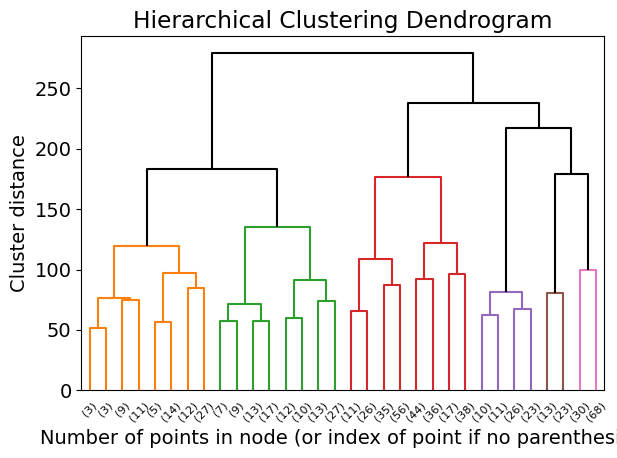

In [190]:
plt.figure()
plt.title('Hierarchical Clustering Dendrogram')
r = plot_dendrogram(model, truncate_mode='level', p=4, color_threshold=178)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel('Cluster distance')
plt.tight_layout()
plt.show()